# Assignment 3
- Train and compare the MLP from Assignment 2 and a simple CNN on the SVHN dataset (available in PyTorch) with optimized hyper-parameters
- Visualize several convolutional kernels and their activations
- Train CNNs with L1, L2, Elastic regularization and No-Regularization. Which method achieves the best results? compare the model performance. With which regularization do you obtain the best results?
- Train CNNs with and without Dropout. Compare the results: accuracy, training time, number of parameters, ...
- Extra Point:
    - Train CNNs with the following Pooling methods: MaxPooling, AvgPooling or a combination of both and compare the results

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
''' Move tensors to cuda/chosen device , dataloader to move data to chosen device'''
def move_to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [move_to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dataloader, device):
    self.dataloader = dataloader
    self.device = device
      
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dataloader: 
      yield move_to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dataloader)

In [ ]:
def calculate_mean_std(dataset):

    image_r = np.dstack([dataset[i][0][0, :, :] for i in range(len(dataset))])
    image_g = np.dstack([dataset[i][0][1, :, :] for i in range(len(dataset))])
    image_b = np.dstack([dataset[i][0][2, :, :] for i in range(len(dataset))])

    mean = (image_r.mean(), image_g.mean(), image_b.mean())
    std = (image_r.std(), image_g.std(), image_b.std())

    return mean, std

In [ ]:
torch.manual_seed(43)

transform = transforms.Compose([transforms.ToTensor()])
                                # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = dsets.SVHN('./data', split='train', download=True, transform=transform)
testset = dsets.SVHN('./data', split='test', download=True, transform=transform)

train_mean, train_std = calculate_mean_std(trainset)
test_mean, test_std = calculate_mean_std(testset)

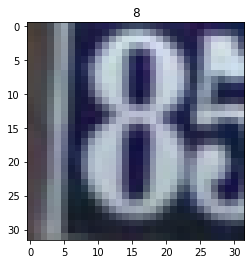

In [ ]:
i = 342
img = trainset[i][0]
_to_pil = transforms.ToPILImage()
plt.imshow(_to_pil(img))
plt.title(trainset.labels[i])
plt.show()

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(train_mean,train_std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(test_mean,test_std)])

trainset = dsets.SVHN('./data', split='train', download=True, transform=train_transform)
testset = dsets.SVHN('./data', split='test', download=True, transform=test_transform)

validation_data_size = np.round(len(trainset)/10) #10% of the training set
training_data_size = len(trainset) - validation_data_size

training_set, validation_set = torch.utils.data.dataset.random_split(trainset, [int(training_data_size), int(validation_data_size)])

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
training_data_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True)
testing_data_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

train_data, train_labels = next(iter(training_data_loader))
validation_data, validation_labels = next(iter(validation_data_loader))
test_data, test_labels = next(iter(testing_data_loader))

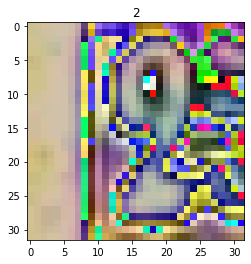

In [ ]:
train_data.shape
i = 32
img = train_data[i]
_to_pil = transforms.ToPILImage()
plt.imshow(_to_pil(img))
plt.title(trainset.labels[train_labels[i]])
plt.show()

In [ ]:
device = get_default_device()
training_data_loader = DeviceDataLoader(training_data_loader, device)
validation_data_loader = DeviceDataLoader(validation_data_loader, device)
testing_data_loader = DeviceDataLoader(testing_data_loader, device)
device

device(type='cuda')

# Helpers

In [ ]:
class Helpers(object):

    def accuracy(self, target_label, predicted_label):

        _, prediction = torch.max(predicted_label, dim=1)
        acc = torch.sum(prediction == target_label).item() / len(prediction)
        return torch.tensor(acc)

    def plot_curves(self, epochs, val_loss, val_acc, lr, epoch):

        fig, ax = plt.subplots(1, 2, figsize=(13,4))
        fig.suptitle(f"curves at learning rate: {lr} and epochs: {epoch}")
        # ax[0].set_title('Loss curve')
        # ax[1].set_title('Accuracy curve')
        ax[0].plot(epochs, val_loss, 'r', label='loss curve')
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("validation loss")
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(epochs, val_acc, 'g', label='accuracy curve')
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("validation accuracy")
        ax[1].legend()
        ax[1].grid()
        plt.show()
        plt.close('fig')

    def confusion_matrix(self, model, test_data_loader):

        cm = np.zeros([10,10])
        with torch.no_grad():
            for images, labels in test_data_loader:
                predictions = model.Forward(images)
                maxPreds, preds = torch.max(predictions, dim=1)
                for idx, label in enumerate(labels):
                    cm[label.item(), preds[idx].item()] += 1 
        return cm

    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)

# Train and compare the MLP from Assignment 2 and a simple CNN on the SVHN dataset (available in PyTorch) with optimized hyper-parameters

In [ ]:
class train_val(object):
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 metric,
                 validation_data_loader,
                 training_data_loader,
                 epoch=10):

        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.metric = metric
        self.val_data_loader = validation_data_loader
        self.train_data_loader = training_data_loader
        self.epoch = epoch

    def train(self, input_image, target_label):

        forward = self.model.Forward(input_image)
        loss = self.loss_function(forward, target_label)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        result = self.metric(target_label, forward)

        return loss, result

    def validation(self, data_loader):

        loss = []
        result = []
        with torch.no_grad():
            for image,label in data_loader:
                forward = self.model.Forward(image)
                loss.append(self.loss_function(forward, label))
                result.append(self.metric(label, forward))

        avg_loss = torch.stack(loss).mean()
        avg_result = torch.stack(result).mean()

        return avg_loss.item(), avg_result.item()

    def fit(self):
        epochs = []
        val_loss_list = []
        val_accu_list = []
        grad_dict = {}
        for i in range(self.epoch):
            for image, label in self.train_data_loader:
                loss, result = self.train(image, label)

            val_loss, val_accu = self.validation(self.val_data_loader)
            epochs.append(i)
            val_loss_list.append(val_loss)
            val_accu_list.append(val_accu)

        print(f"Epoch [{self.epoch}/{self.epoch}], Loss: {np.round(val_loss, 2)}, accuracy: {np.round(val_accu*100, 2)}")

        return epochs, val_loss_list, val_accu_list

In [ ]:
shape = train_data[0].shape
input_size = shape[0]*shape[1]*shape[2]
output_size = len(np.unique(trainset.labels))

class MLP_svhn(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 64)
    self.linear4 = nn.Linear(64, 64)
    self.linear5 = nn.Linear(64, output_size)


  def Forward(self, input_image):
    output = input_image.view(input_image.size(0), -1)
    output = self.linear1(output)
    output = Functions.relu(output)
    output = self.linear2(output)
    output = Functions.relu(output)
    output = self.linear3(output)
    output = Functions.relu(output)
    output = self.linear4(output)
    output = Functions.relu(output)
    output = self.linear5(output)
    return output

In [ ]:
class CNN_svhn(nn.Module):

    def __init__(self):
        super().__init__()
        self.convolution_block = nn.Sequential(
            #Block1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            #Block2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            #Block3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.FCN = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def Forward(self, input_data):
        output = self.convolution_block(input_data)

        output = output.view(output.size(0), -1)

        output = self.FCN(output)

        return output

In [ ]:
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import Trials

In [ ]:
np.arange(10, 100, 10, dtype=int)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [ ]:
space = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'alpha': hp.uniform('alpha', 0.0, 1.0),
         'epoch': hp.choice('epoch', np.arange(10, 100, 10, dtype=int))}


def objective_MLP(params):
    lr = params['learning_rate']
    alpha = params['alpha']
    epoch = params['epoch']
    model = move_to_device(MLP_svhn(), device)
    loss_function = Functions.cross_entropy
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=alpha)
    model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
    # loss = test_fit1(model, loss_function, optimizer, training_data_loader, validation_data_loader, accuracy, epoch=10)
    torch.cuda.empty_cache()
    epochs, validation_loss, validation_accuracy = model_fit.fit()
    loss = validation_loss[-1]
    return {'loss': loss, 'status': STATUS_OK}

bayes_trials = Trials()
tpe_algorithm = tpe.suggest
MAX_EVALS = 5

# Run optimization
best_MLP = fmin(fn = objective_MLP, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
print(f"best_MLP: {best_MLP}")

Epoch [80/80], Loss: 0.94, accuracy: 84.74
Epoch [10/10], Loss: 1.0, accuracy: 76.6
Epoch [30/30], Loss: 0.8, accuracy: 83.98
Epoch [90/90], Loss: 1.26, accuracy: 81.7
Epoch [90/90], Loss: 1.05, accuracy: 82.83
100%|██████████| 5/5 [1:10:39<00:00, 847.92s/it, best loss: 0.8025892376899719]
best_MLP: {'alpha': 0.6456117742949911, 'epoch': 2, 'learning_rate': 0.04554318718194167}
0it [00:00, ?it/s, best loss: ?]
best_CNN: {'alpha': 0.6456117742949911, 'epoch': 2, 'learning_rate': 0.04554318718194167}


In [ ]:
space = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'alpha': hp.uniform('alpha', 0.0, 1.0),
         'epoch': hp.choice('epoch', np.arange(10, 100, 10, dtype=int))}

def objective_CNN(params):
    lr = params['learning_rate']
    alpha = params['alpha']
    epoch = params['epoch']
    model = move_to_device(CNN_svhn(), device)
    loss_function = Functions.cross_entropy
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=alpha)
    model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
    # loss = test_fit1(model, loss_function, optimizer, training_data_loader, validation_data_loader, accuracy, epoch=10)
    torch.cuda.empty_cache()
    epochs, validation_loss, validation_accuracy = model_fit.fit()
    loss = validation_loss[-1]
    return {'loss': loss, 'status': STATUS_OK}

bayes_trials = Trials()
tpe_algorithm = tpe.suggest
MAX_EVALS = 5

best_CNN = fmin(fn = objective_CNN, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
print(f"best_CNN: {best_CNN}")

Epoch [60/60], Loss: 0.36, accuracy: 93.93
Epoch [30/30], Loss: 4.49, accuracy: 59.94
Epoch [20/20], Loss: 0.24, accuracy: 92.99
Epoch [10/10], Loss: 0.25, accuracy: 92.98
Epoch [10/10], Loss: 0.29, accuracy: 91.94
100%|██████████| 5/5 [1:06:26<00:00, 797.25s/it, best loss: 0.2444962114095688]
best_CNN: {'alpha': 0.32824260428699836, 'epoch': 1, 'learning_rate': 0.011334895131900134}


Epoch [30/30], Loss: 0.86, accuracy: 82.92
Training and validation results for MLP
Epoch:30, Learning rate:0.045, Validation loss:0.86, and Validation accuracy:82.92
Epoch:30, Learning rate:0.045, Testing loss:0.97, and Testing accuracy:80.65


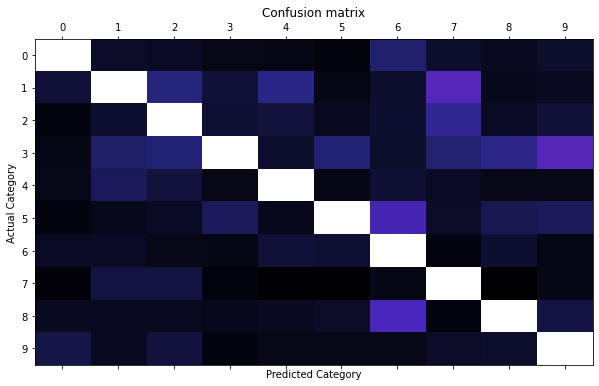

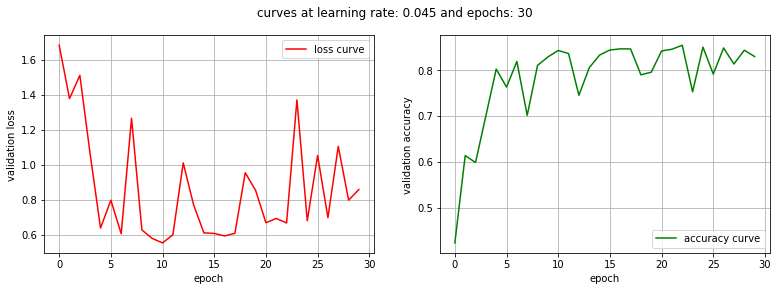

In [ ]:
model = move_to_device(MLP_svhn(), device)
lr=0.045
epoch = 30
optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.6456)
loss_function = Functions.cross_entropy
model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
torch.cuda.empty_cache()
epochs, validation_loss, validation_accuracy = model_fit.fit()
test_loss, test_accuracy = model_fit.validation(testing_data_loader)
print(f"Training and validation results for MLP")
print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
cm = Helpers().confusion_matrix(model, testing_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), np.unique(trainset.labels))
plt.xlabel('Predicted Category')
plt.xticks(range(10), np.unique(trainset.labels))
plt.show()
Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)

Epoch [60/60], Loss: 0.41, accuracy: 92.74
Training and validation results for CNN
Epoch:60, Learning rate:0.011, Validation loss:0.41, and Validation accuracy:92.74
Epoch:60, Learning rate:0.011, Testing loss:0.42, and Testing accuracy:92.54


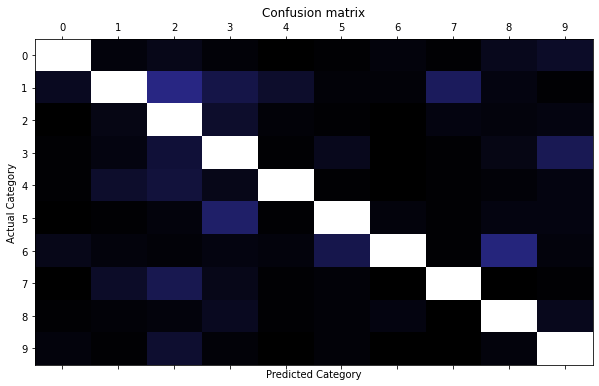

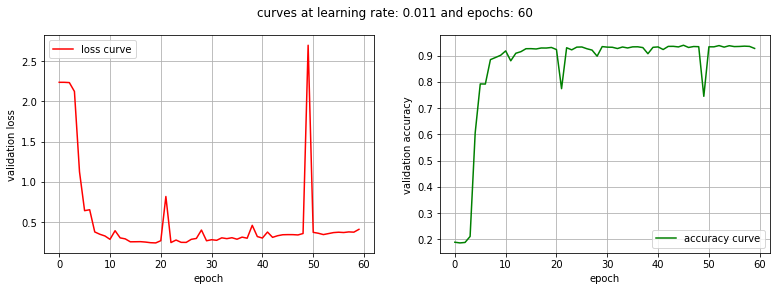

In [ ]:
model = move_to_device(CNN_svhn(), device)
lr=0.011
epoch = 60
optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.3282)
loss_function = Functions.cross_entropy
model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
torch.cuda.empty_cache()
epochs, validation_loss, validation_accuracy = model_fit.fit()
test_loss, test_accuracy = model_fit.validation(testing_data_loader)
print(f"Training and validation results for CNN")
print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
cm = Helpers().confusion_matrix(model, testing_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), np.unique(trainset.labels))
plt.xlabel('Predicted Category')
plt.xticks(range(10), np.unique(trainset.labels))
plt.show()
Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)

Here we used hyperopt library to determine the best hyperparameters for training both the MLP and CNN using the SVHN dataseet. Based on the resource availability, we choose to look for three hyperparameter and obtain best values for them. The three hyperparameters are, number of epochs, alpha parameter in the optimizer and the learning rate.

With these three, we trained bot simple MLP and a simple CNN network and checked for results. From above loss curves and accuracy curves we can see that the simple CNN performs better classification than an MLP. We can see that the simple CNN network out performs the MLP network by over 10%.

From the confusion matrix as well, we can see that the MLP shows more number of false positives than the simple CNN. Since CNN makes use of convolution operations CNNs work better on the image data.

# Visualize several convolutional kernels and their activations

Activations:
Activations for convolution layer 1


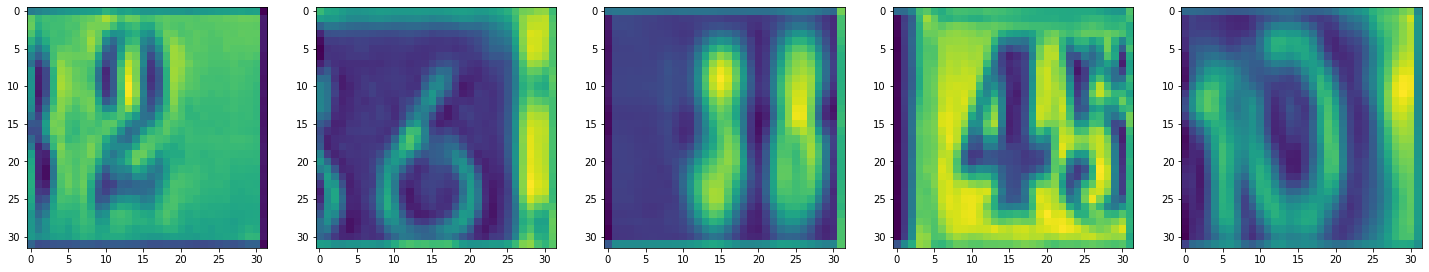

**********************************************************************************
Activations for convolution layer 2


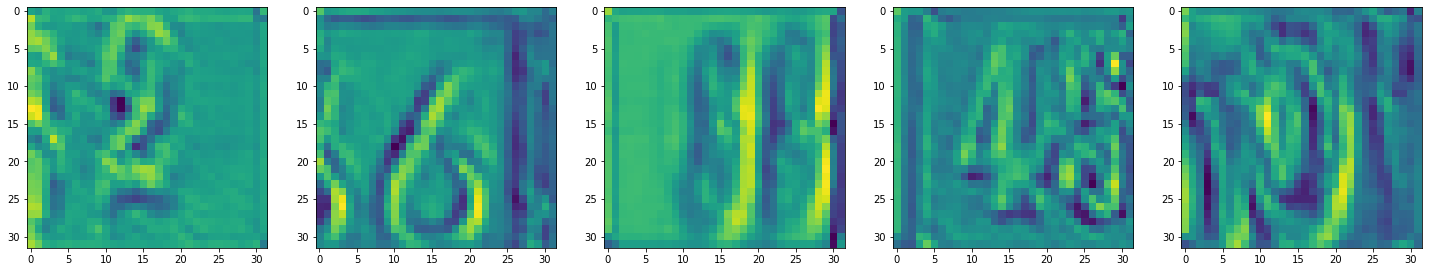

**********************************************************************************
Activations for convolution layer 3


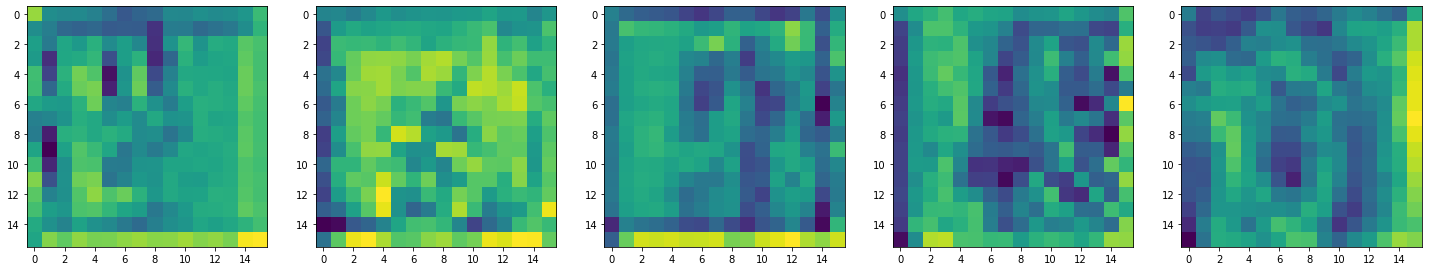

**********************************************************************************
Activations for convolution layer 4


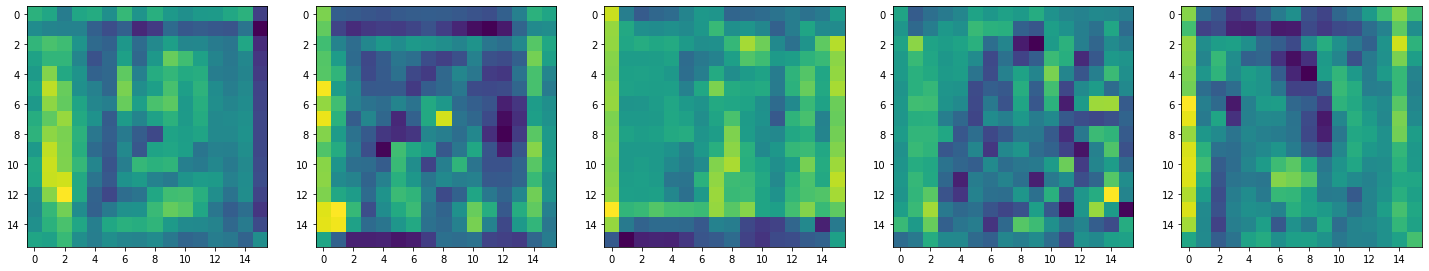

**********************************************************************************
Activations for convolution layer 5


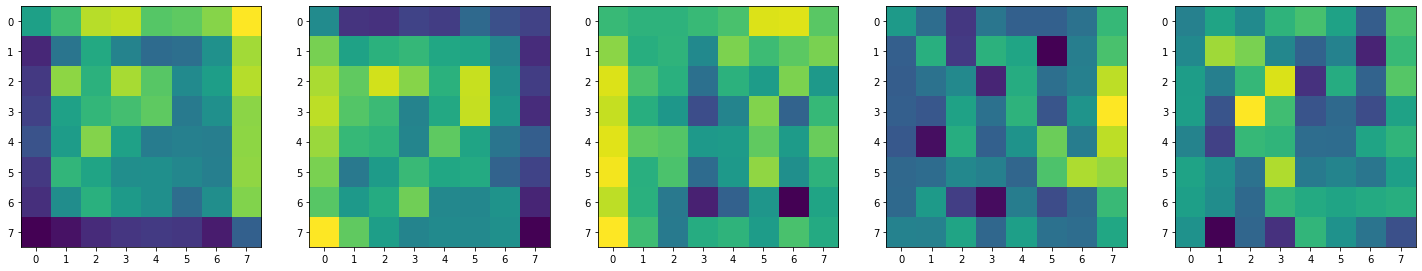

**********************************************************************************
Activations for convolution layer 6


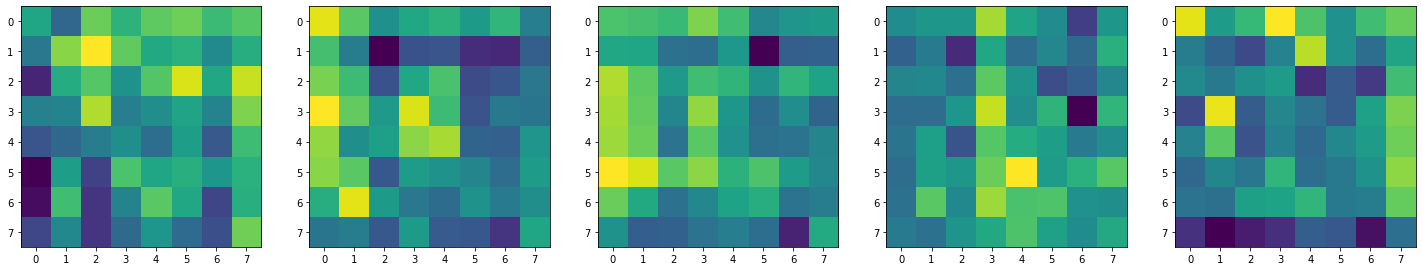

**********************************************************************************


In [ ]:
print("Activations:")
images, labels = next(iter(training_data_loader))
num_plot = 5
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.cpu().detach().numpy()
    return hook

model_cnn = move_to_device(CNN_svhn(), device)
j = 0
for i in range(len(model_cnn.convolution_block)):
    temp = str(model_cnn.convolution_block[i])
    if 'Conv2d' in temp:
        j += 1    
        model_cnn.convolution_block[i].register_forward_hook(get_activation(str(i)))
        output = model_cnn.Forward(images)

        act = activation[str(i)].squeeze()
        print("Activations for convolution layer {}".format(j))
        fig, axarr = plt.subplots(nrows=1, ncols=5, figsize=(25,25), )
        for idx in range(min(act.shape[0], num_plot)):
            axarr[idx].imshow(act[idx,1,:,:])
        plt.show()
        print("**********************************************************************************")

Displaying only few of the kernels
torch.Size([32, 3, 3, 3])
Kernel for convolution layer 1


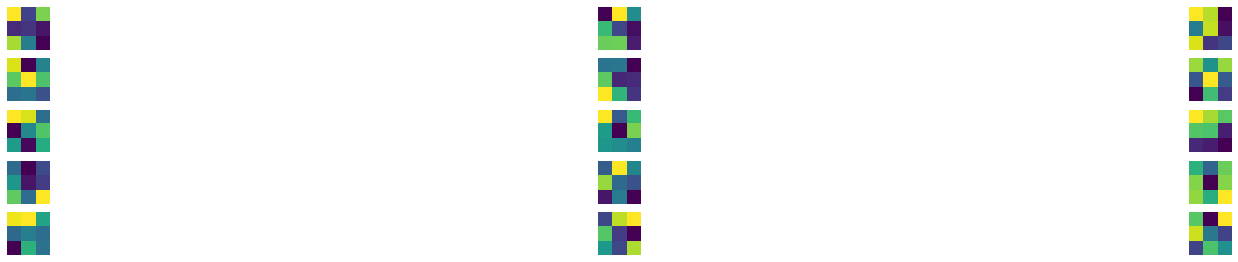

**********************************************************************************
torch.Size([64, 32, 3, 3])
Kernel for convolution layer 2


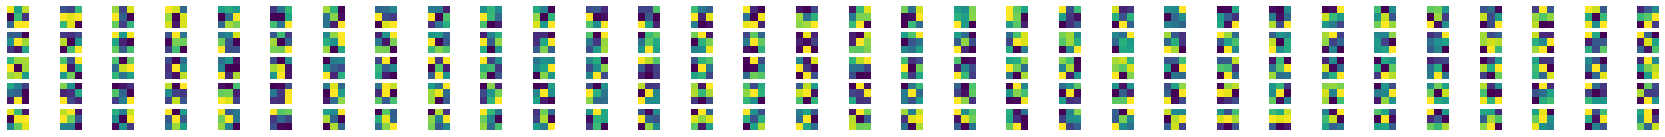

**********************************************************************************
torch.Size([128, 64, 3, 3])
Kernel for convolution layer 3


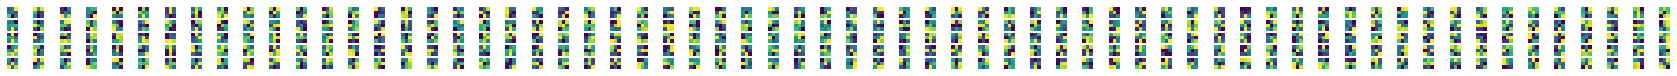

**********************************************************************************
torch.Size([128, 128, 3, 3])
Kernel for convolution layer 4


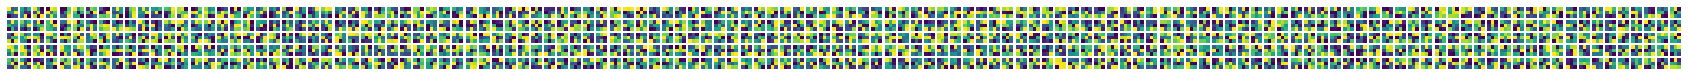

**********************************************************************************
torch.Size([256, 128, 3, 3])
Kernel for convolution layer 5


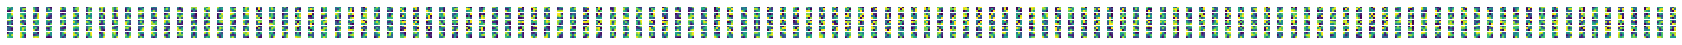

**********************************************************************************
torch.Size([256, 256, 3, 3])
Kernel for convolution layer 6


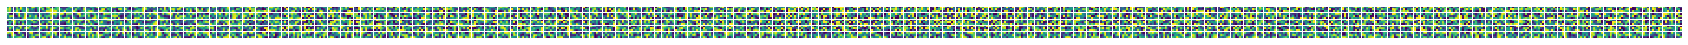

**********************************************************************************


In [ ]:
from torchvision.utils import make_grid
from matplotlib import gridspec
#execute above code block before this
print("Displaying only few of the kernels")
j = 0
for i in range(len(model_cnn.convolution_block)):
    temp = str(model_cnn.convolution_block[i])
    if 'Conv2d' in temp:
        j += 1
        kernels = model_cnn.convolution_block[i].weight
        print(kernels.shape)
        kernels = kernels.cpu().clone().detach().numpy()
        kernels = torch.tensor(kernels)
        print("Kernel for convolution layer {}".format(j))
        fig = plt.figure(constrained_layout=False, figsize=(30,30))
        height_ratios = np.ones(kernels.shape[0]) + 2
        width_ratios = np.ones(kernels.shape[1]) + 2
        spec = fig.add_gridspec(nrows=kernels.shape[0], ncols=kernels.shape[1], width_ratios=width_ratios, height_ratios=height_ratios)
        counter_in = 0
        counter_out = 0
        for out_image in kernels:
            counter_in = 0
            if counter_out == 5:
                break
            for in_image in out_image:
                fig.add_subplot(spec[counter_out, counter_in])
                plt.imshow(in_image, )
                plt.axis('off')
                counter_in += 1
            counter_out += 1
        plt.show()
        print("**********************************************************************************")

# Train CNNs with L1, L2, Elastic regularization and No-Regularization. Which method achieves the best results? compare the model performance. With which regularization do you obtain the best results?

In [ ]:
class Regularization(object):

    def __init__(self, parameters, lambda_reg, alpha_reg):
        self.parameters = parameters
        self.lambda_reg = lambda_reg
        self.alpha_reg = alpha_reg

    def L1(self):

        reg = 0
        for param in self.parameters:
            reg = reg + torch.norm(param, 1)

        return self.lambda_reg * reg

    def L2(self):

        reg = 0
        for param in self.parameters:
            reg = reg + torch.pow(torch.norm(param, 2), 2)

        return self.lambda_reg * reg

    def ElasticNet(self):

        reg = 0
        for param in self.parameters:
            reg = reg + (((1-self.alpha_reg)*torch.norm(param,1)) + (self.alpha_reg*torch.pow(torch.norm(param, 2), 2)))

        return self.lambda_reg * reg

In [ ]:
class reg_train_val(object):
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 metric,
                 validation_data_loader,
                 training_data_loader,
                 epoch=10):

        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.metric = metric
        self.val_data_loader = validation_data_loader
        self.train_data_loader = training_data_loader
        self.epoch = epoch

    def train(self, input_image, target_label, reg):

        forward = self.model.Forward(input_image)
        if reg == 'L1':
            loss = self.loss_function(forward, target_label)
            loss = loss + Regularization(self.model.parameters(), 0.001, 0.25).L1()
        elif reg == 'L2':
            loss = self.loss_function(forward, target_label)
            loss = loss + Regularization(self.model.parameters(), 0.001, 0.25).L2()
        elif reg == 'ElasticNet':
            loss = self.loss_function(forward, target_label)
            loss = loss + Regularization(self.model.parameters(), 0.001, 0.25).ElasticNet()
        else:
            loss = self.loss_function(forward, target_label)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        result = self.metric(target_label, forward)

        return loss, result

    def validation(self, data_loader):

        loss = []
        result = []
        with torch.no_grad():
            for image,label in data_loader:
                forward = self.model.Forward(image)
                loss.append(self.loss_function(forward, label))
                result.append(self.metric(label, forward))

        avg_loss = torch.stack(loss).mean()
        avg_result = torch.stack(result).mean()

        return avg_loss.item(), avg_result.item()

    def fit(self, reg=None):
        epochs = []
        val_loss_list = []
        val_accu_list = []
        grad_dict = {}
        for i in range(self.epoch):
            for image, label in self.train_data_loader:
                loss, result = self.train(image, label, reg)

            val_loss, val_accu = self.validation(self.val_data_loader)
            epochs.append(i)
            val_loss_list.append(val_loss)
            val_accu_list.append(val_accu)

        print(f"Epoch [{self.epoch}/{self.epoch}], Loss: {np.round(val_loss, 2)}, accuracy: {np.round(val_accu*100, 2)}")

        return epochs, val_loss_list, val_accu_list

Epoch [60/60], Loss: 2.24, accuracy: 18.66
Results for L1 regularization method
Epoch:60, Learning rate:0.011, Validation loss:2.24, and Validation accuracy:18.66
Epoch:60, Learning rate:0.011, Testing loss:2.22, and Testing accuracy:19.59


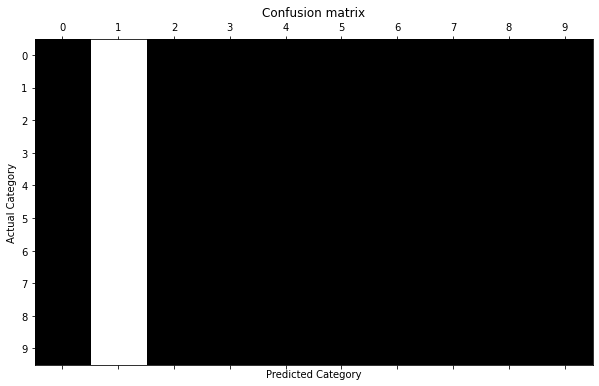

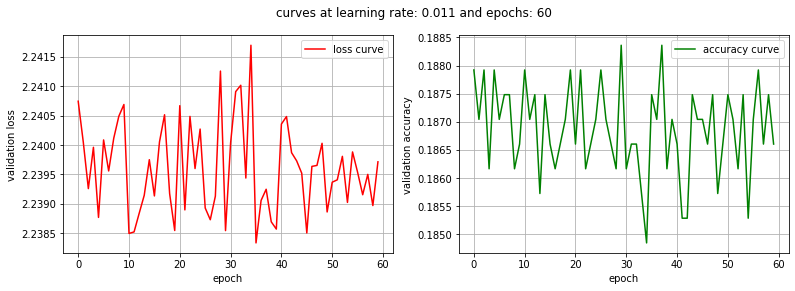

******************************************************************************************************************************************************************************************************************
Epoch [60/60], Loss: 0.26, accuracy: 93.24
Results for L2 regularization method
Epoch:60, Learning rate:0.011, Validation loss:0.26, and Validation accuracy:93.24
Epoch:60, Learning rate:0.011, Testing loss:0.25, and Testing accuracy:93.33


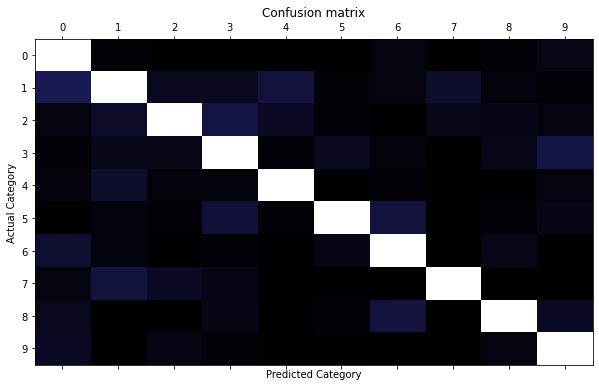

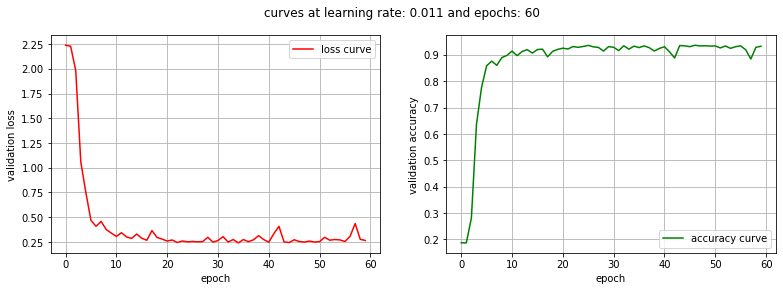

******************************************************************************************************************************************************************************************************************
Epoch [60/60], Loss: 2.24, accuracy: 18.57
Results for ElasticNet regularization method
Epoch:60, Learning rate:0.011, Validation loss:2.24, and Validation accuracy:18.57
Epoch:60, Learning rate:0.011, Testing loss:2.22, and Testing accuracy:19.59


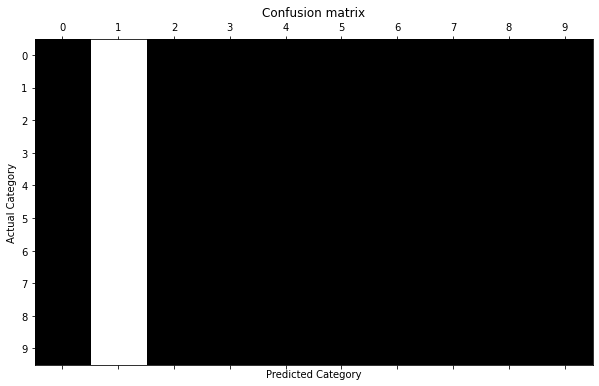

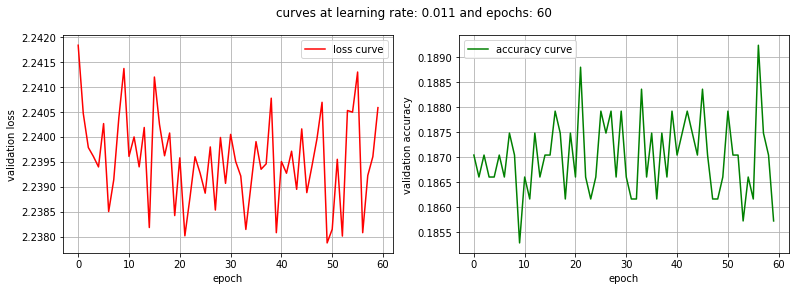

******************************************************************************************************************************************************************************************************************


In [ ]:
regularization_methods = ['L1', 'L2', 'ElasticNet']
torch.cuda.empty_cache()
for reg_method in regularization_methods:
    torch.cuda.empty_cache()
    model = move_to_device(CNN_svhn(), device)
    lr=0.011
    epoch = 60
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.3282)
    loss_function = Functions.cross_entropy
    model_fit = reg_train_val(model,
                              loss_function,
                              optimizer,
                              Helpers().accuracy,
                              validation_data_loader,
                              training_data_loader,
                              epoch=epoch)
    epochs, validation_loss, validation_accuracy = model_fit.fit(reg_method)
    test_loss, test_accuracy = model_fit.validation(testing_data_loader)
    print(f"Results for {reg_method} regularization method")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
    cm = Helpers().confusion_matrix(model, testing_data_loader)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
    plt.title("Confusion matrix")
    plt.ylabel('Actual Category')
    plt.yticks(range(10), np.unique(trainset.labels))
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), np.unique(trainset.labels))
    plt.show()
    Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)
    print('*******'*30)

From above results we cuold see that the L1 regularization do not penalize the loss function as expected and the learning does not happen as expected. It can be seen by observing the accuracy and the losses. The same is supported by the confusion matrix. Hence we suggest not to use the L1 regularization in this example.

The L2 regularization works much better and shows a good performance. The same can be observed in the loss and accuracy surves along with the confusion matrix. The performance here is similar to that of the model with no regularization, but the performance with L2 regularization is increased by 1% compared to the model with no regularization.

The ElasticNet regularization technique is basically the combination of both L1 and L2 but it is scaled by a factor of 'alpha'. The selection of this hyperparameter plays a very important role in choosing this regularization method. Due to the value choosen in this example, the value most favors the L1 regularization and hence for this example the performace of the network when compared to the model with only L2 regularization is less. Hence we do not suggest to use this regularization technique here. In case if alpha is around 0.9, then we could favour the use of ElasticNet regularization method. If alpha is 1, then it is same as L2 regularization.

We would prefer to use the L2 regularization over L1 and ElasticNet regularization techniques in this example.

# Train CNNs with and without Dropout. Compare the results: accuracy, training time, number of parameters, ...

In [ ]:
class CNN_svhn_with_dropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.convolution_block = nn.Sequential(
            #Block1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            #Block2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            #Block3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.FCN = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def Forward(self, input_data):
        output = self.convolution_block(input_data)

        output = output.view(output.size(0), -1)

        output = self.FCN(output)

        return output

In [ ]:
class CNN_svhn_without_dropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.convolution_block = nn.Sequential(
            #Block1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.FCN = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def Forward(self, input_data):
        output = self.convolution_block(input_data)

        output = output.view(output.size(0), -1)

        output = self.FCN(output)

        return output

Epoch [60/60], Loss: 0.44, accuracy: 92.85
Results for with dropout:
Time for training with dropout is 1784.9492156505585 seconds
Epoch:60, Learning rate:0.011, Validation loss:0.44, and Validation accuracy:92.85
Epoch:60, Learning rate:0.011, Testing loss:0.38, and Testing accuracy:93.48


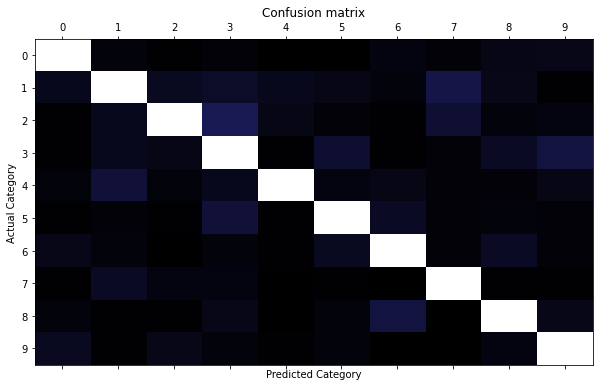

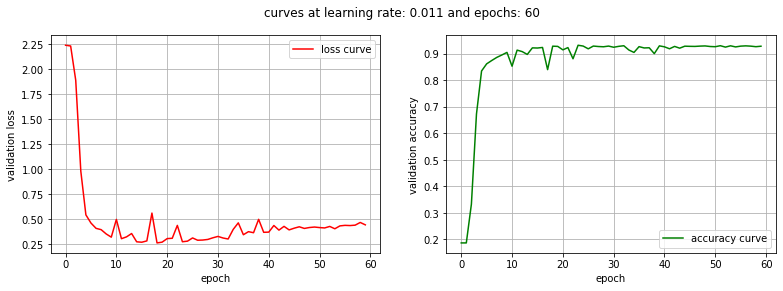

******************************************************************************************************************************************************************************************************************
Epoch [60/60], Loss: 0.45, accuracy: 93.59
Results for without dropout:
Time for training without dropout is 1783.9696145057678 seconds
Epoch:60, Learning rate:0.011, Validation loss:0.45, and Validation accuracy:93.59
Epoch:60, Learning rate:0.011, Testing loss:0.43, and Testing accuracy:93.35


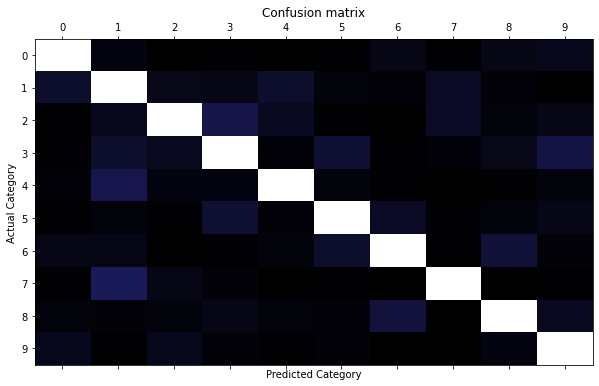

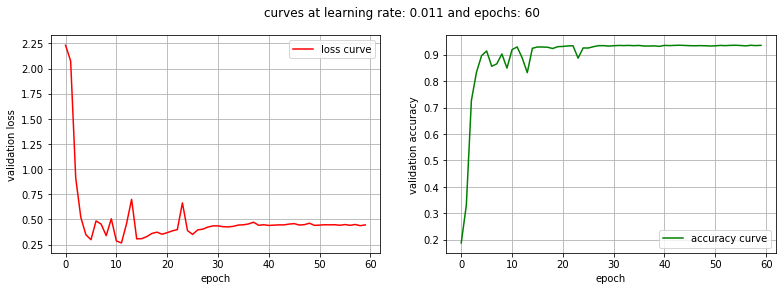

******************************************************************************************************************************************************************************************************************


In [ ]:
dropout = ['with dropout', 'without dropout']
torch.cuda.empty_cache()
for dp in dropout:
    torch.cuda.empty_cache()
    if dp == 'with dropout':
        model = move_to_device(CNN_svhn_with_dropout(), device)
    elif dp == 'without dropout':
        model = move_to_device(CNN_svhn_without_dropout(), device)
    lr=0.011
    epoch = 60
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.3282)
    loss_function = Functions.cross_entropy
    model_fit = train_val(model,
                          loss_function,
                          optimizer,
                          Helpers().accuracy,
                          validation_data_loader,
                          training_data_loader,
                          epoch=epoch)
    start = time.time()
    epochs, validation_loss, validation_accuracy = model_fit.fit()
    end = time.time()
    test_loss, test_accuracy = model_fit.validation(testing_data_loader)
    print(f"Results for {dp}:")
    print(f"Time for training {dp} is {end - start} seconds")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
    cm = Helpers().confusion_matrix(model, testing_data_loader)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
    plt.title("Confusion matrix")
    plt.ylabel('Actual Category')
    plt.yticks(range(10), np.unique(trainset.labels))
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), np.unique(trainset.labels))
    plt.show()
    Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)
    print('*******'*30)

As can be seen, the CNN network designed for this exercise is comparatively smaller in size and do not have more convolution blocks. And hence we could not find much difference between the two models (one with dropout and other without dropout). From the concepts dropout generally referes to switching of some neurons randomly during the training phase. The model that has dropout regularization, has less number of parameters compared to the one without the dropout. 

Due to the small network, the presence of dropout did not make much difference when compared to the model without dropout.

For this particular dataset, from above outputs we can see that there is a 1% improvement in the accuracy when there is no dropout.

# Extra Point:
Train CNNs with the following Pooling methods: MaxPooling, AvgPooling or a combination of both and compare the results

In [ ]:
class CNN_svhn_Pooling(nn.Module):

    def __init__(self, pooling):
        super().__init__()
        self.pooling = pooling
        self.convolution_block = nn.Sequential(
            #Block1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            self.pooling(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            #Block2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            self.pooling(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            #Block3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            self.pooling(kernel_size=2, stride=2))
        
        self.FCN = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def Forward(self, input_data):
        output = self.convolution_block(input_data)

        output = output.view(output.size(0), -1)

        output = self.FCN(output)

        return output


In [ ]:
class CNN_svhn_concat(nn.Module):

    def __init__(self):
        super().__init__()
        #Block1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(p=0.2)

        #Block2
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.drop2 = nn.Dropout2d(p=0.3)

        #Block3
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.linear0 = nn.Linear(8192, 4096)
        self.linear1 = nn.Linear(4096, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 10)
        

    def Forward(self, input_data):
        output = self.conv1(input_data)
        output = self.batchnorm1(output)
        output = Functions.relu(output)
        output = self.conv2(output)
        output = Functions.relu(output)
        o1 = self.maxpool1(output)
        o2 = self.avgpool1(output)
        output = torch.cat((o1, o2), dim=1)
        output = self.drop1(output)

        output = self.conv3(output)
        output = self.batchnorm2(output)
        output = Functions.relu(output)
        output = self.conv4(output)
        output = Functions.relu(output)
        o3 = self.maxpool1(output)
        o4 = self.avgpool1(output)
        output = torch.cat((o3, o4), dim=1)
        output = self.drop2(output)

        output = self.conv5(output)
        output = self.batchnorm3(output)
        output = Functions.relu(output)
        output = self.conv6(output)
        output = Functions.relu(output)
        o5 = self.maxpool1(output)
        o6 = self.avgpool1(output)
        output = torch.cat((o5, o6), dim=1)
        
        output = output.view(output.size(0), -1)
        output = self.linear0(output)
        output = Functions.relu(output)
        output = self.linear1(output)
        output = Functions.relu(output)
        output = self.linear2(output)
        output = Functions.relu(output)
        output = self.linear3(output)
        output = Functions.relu(output)
        output = self.linear4(output)
        output = Functions.relu(output)
        output = self.linear5(output)

        return output


Epoch [60/60], Loss: 0.37, accuracy: 93.41
Results for MaxPooling method:
Time for training without dropout is 1796.4888756275177 seconds
Epoch:60, Learning rate:0.011, Validation loss:0.37, and Validation accuracy:93.41
Epoch:60, Learning rate:0.011, Testing loss:0.38, and Testing accuracy:93.67


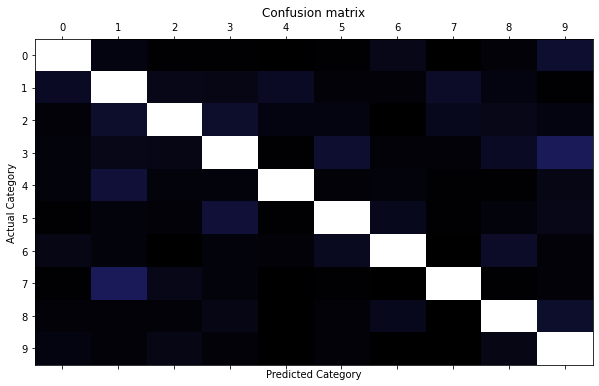

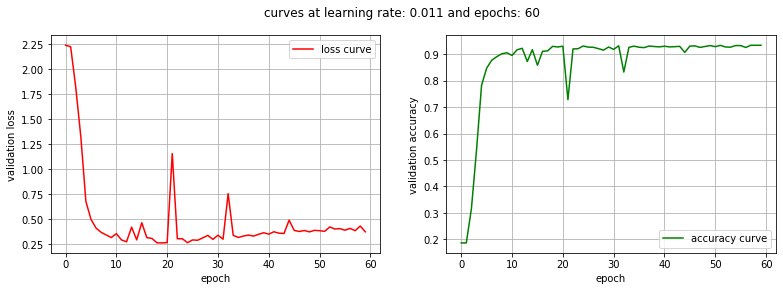

******************************************************************************************************************************************************************************************************************
Epoch [60/60], Loss: 0.31, accuracy: 93.45
Results for AvgPooling method:
Time for training without dropout is 1817.046292066574 seconds
Epoch:60, Learning rate:0.011, Validation loss:0.31, and Validation accuracy:93.45
Epoch:60, Learning rate:0.011, Testing loss:0.29, and Testing accuracy:93.81


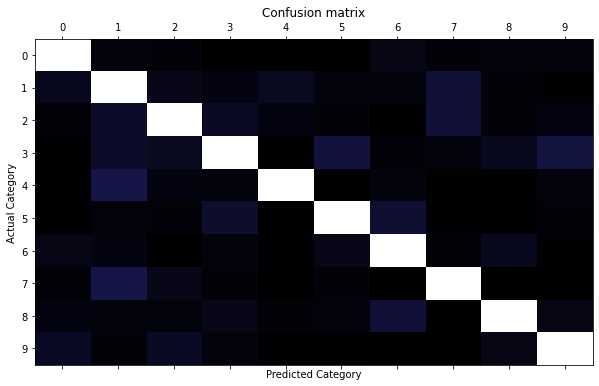

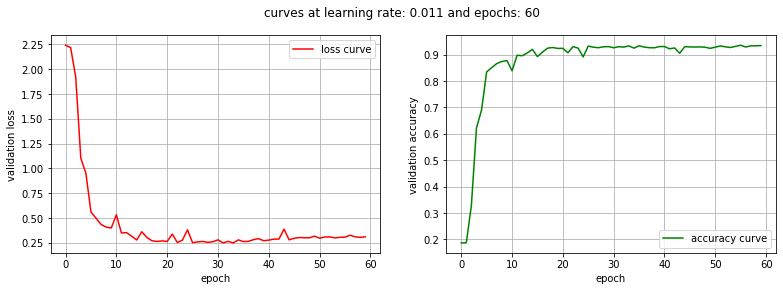

******************************************************************************************************************************************************************************************************************
Epoch [60/60], Loss: 0.4, accuracy: 93.59
Results for CombiPooling method:
Time for training without dropout is 2250.8132100105286 seconds
Epoch:60, Learning rate:0.011, Validation loss:0.4, and Validation accuracy:93.59
Epoch:60, Learning rate:0.011, Testing loss:0.41, and Testing accuracy:93.65


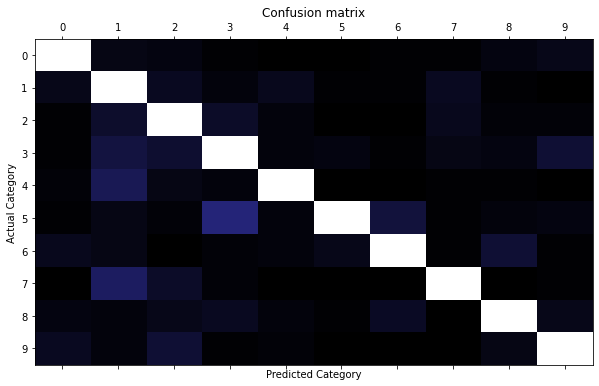

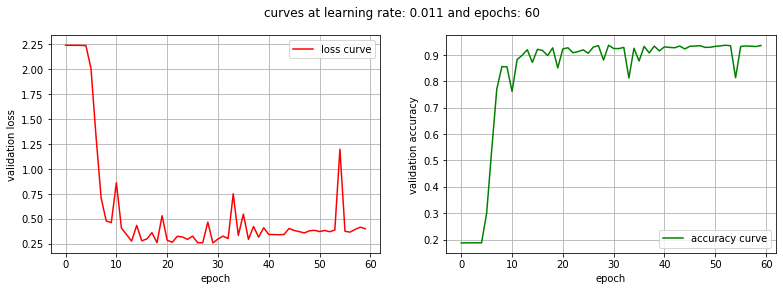

******************************************************************************************************************************************************************************************************************


In [ ]:
torch.cuda.empty_cache()
pool_list = ['MaxPooling', 'AvgPooling', 'CombiPooling']
for pool in pool_list:
    torch.cuda.empty_cache()
    if pool == 'MaxPooling':
        model = move_to_device(CNN_svhn_Pooling(nn.MaxPool2d), device)
    elif pool == 'AvgPooling':
        model = move_to_device(CNN_svhn_Pooling(nn.AvgPool2d), device)
    elif pool == 'CombiPooling':
        model = move_to_device(CNN_svhn_concat(), device)
    lr=0.011
    epoch = 60
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.3282)
    loss_function = Functions.cross_entropy
    model_fit = train_val(model,
                          loss_function,
                          optimizer,
                          Helpers().accuracy,
                          validation_data_loader,
                          training_data_loader,
                          epoch=epoch)
    start = time.time()
    epochs, validation_loss, validation_accuracy = model_fit.fit()
    end = time.time()
    test_loss, test_accuracy = model_fit.validation(testing_data_loader)
    print(f"Results for {pool} method:")
    print(f"Time for training {dp} is {end - start} seconds")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
    print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
    cm = Helpers().confusion_matrix(model, testing_data_loader)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
    plt.title("Confusion matrix")
    plt.ylabel('Actual Category')
    plt.yticks(range(10), np.unique(trainset.labels))
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), np.unique(trainset.labels))
    plt.show()
    Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)
    print('*******'*30)

As seen from above results, the pooling methods like average pooling and maxpooling did not affect the training accuracy or the validation accuracy. One this to suspect for this reason is because of the sparsity of the images.

For a dense data, the average pooling and the maxpooling would definitely make a difference because of the use of different calculation techniques used during the pooling.

Or the kernel size and stride might affect the learning capacity of the network based on the data. 

Even the combination of both the pooling techniques do not make much of a difference in training and validating the simple CNN using the SVHN dataset.